In [3]:
#!pip install transformers==3.0.2 essential_generators

# Test sentence embedding with local deployment of "Roberta-base" model

In [11]:
%%time

import json
import torch
from torch import nn
# Roberta Model and Tokenizer
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer, BertModel
import os
import pickle

CPU times: user 713 ms, sys: 35.9 ms, total: 749 ms
Wall time: 1.01 s


In [12]:
%%time

# Initialize tokenizer and model from HuggingFaces
JSON_CONTENT_TYPE = 'application/json'
PRE_TRAINED_MODEL_NAME = 'roberta-base'
# CLASS_NAMES = ['negative', 'neutral', 'positive']
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 160

CPU times: user 4.4 s, sys: 667 ms, total: 5.06 s
Wall time: 8.42 s


In [13]:
%%time

test_data = {"text": "AWS is excited to announce that TorchServe is natively supported in Amazon SageMaker as the default model server for PyTorch inference"}
review_text = test_data['text']
print(review_text)

AWS is excited to announce that TorchServe is natively supported in Amazon SageMaker as the default model server for PyTorch inference
CPU times: user 76 µs, sys: 0 ns, total: 76 µs
Wall time: 80.6 µs


In [14]:
%%time

encoded_review = tokenizer.encode_plus(
                                        review_text,
                                        max_length=MAX_LEN,
                                        add_special_tokens=True,
                                        return_token_type_ids=False,
                                        padding=True,
                                        return_attention_mask=True,
                                        return_tensors='pt',
                                        )

input_ids = encoded_review['input_ids']
attention_mask = encoded_review['attention_mask']

CPU times: user 2.65 ms, sys: 0 ns, total: 2.65 ms
Wall time: 3.88 ms


In [15]:
%%time

output = model(input_ids, attention_mask)

embedding = pickle.dumps(output)
decoded_embedding = pickle.loads(embedding)

#print(embedding)

CPU times: user 156 ms, sys: 7.86 ms, total: 164 ms
Wall time: 328 ms


## Save HuggingFaces model and tokenizer assets into local directory

In [7]:
%%bash
if [ -d "local_model_directory" ]; then
    rm -f local_model_directory/*    
else
    mkdir local_model_directory
fi

In [8]:
import os.path

local_model_path_var = os.path.join('./', 'local_model_directory')

tokenizer.save_pretrained(local_model_path_var)
model.save_pretrained(local_model_path_var)

In [9]:
!ls -alh {local_model_path_var}

total 477M
drwxrwxr-x 2 ec2-user ec2-user 4.0K Jul  6 18:25 .
drwxrwxr-x 5 ec2-user ec2-user 4.0K Jul  6 18:25 ..
-rw-rw-r-- 1 ec2-user ec2-user  510 Jul  6 18:25 config.json
-rw-rw-r-- 1 ec2-user ec2-user 446K Jul  6 18:25 merges.txt
-rw-rw-r-- 1 ec2-user ec2-user 476M Jul  6 18:25 pytorch_model.bin
-rw-rw-r-- 1 ec2-user ec2-user  772 Jul  6 18:25 special_tokens_map.json
-rw-rw-r-- 1 ec2-user ec2-user   25 Jul  6 18:25 tokenizer_config.json
-rw-rw-r-- 1 ec2-user ec2-user 878K Jul  6 18:25 vocab.json


In [27]:
s3_bucket = "eks-sagemaker-us-east-1-bucket-mars"

In [30]:
%%bash
(cd local_model_directory ; tar -czvf roberta-base.tar.gz *)

config.json
merges.txt
pytorch_model.bin
special_tokens_map.json
tokenizer_config.json
vocab.json


In [31]:
%%bash 
mv local_model_directory/roberta-base.tar.gz .

In [38]:
%%bash
aws s3 cp roberta-base.tar.gz s3://eks-sagemaker-us-east-1-bucket-mars/roberta/

upload: ./roberta-base.tar.gz to s3://eks-sagemaker-us-east-1-bucket-mars/roberta/roberta-base.tar.gz


# Create 3000 copies of roberta-base model

In [ ]:
%%sh

#Replace S3 Bucket

s3_bucket='eks-sagemaker-us-east-1-bucket-mars'

for i in {0..2999}
do
  aws s3 cp roberta-base.tar.gz s3://$s3_bucket/roberta/roberta-base-$i.tar.gz 
done

In [33]:
#Make sure all 3000 models loaded in bucket
#!aws s3 ls s3://eks-sagemaker-us-east-1-bucket-mars/roberta/

# SageMaker endpoint deployment

In [41]:
%%sh

# The name of our algorithm
algorithm_name=nlp-sagemaker-multimodel

cd container

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build -q -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded
sha256:8aa678f5d3963a9930ead4b72e29cff8017da98a0034d96a9c609bb961bbfd3c
The push refers to repository [474422712127.dkr.ecr.us-east-1.amazonaws.com/nlp-sagemaker-multimodel]
af83b501136f: Preparing
07f2b2f89807: Preparing
1560f87c4e4a: Preparing
71690dc33eea: Preparing
604dc4e32a22: Preparing
81c0c646deb8: Preparing
fec20c668cb5: Preparing
03d61bce70c7: Preparing
f6aa281a2333: Preparing
8f8f0266f834: Preparing
81c0c646deb8: Waiting
fec20c668cb5: Waiting
03d61bce70c7: Waiting
f6aa281a2333: Waiting
8f8f0266f834: Waiting
07f2b2f89807: Pushed
af83b501136f: Pushed
1560f87c4e4a: Pushed
71690dc33eea: Pushed
604dc4e32a22: Pushed
fec20c668cb5: Pushed
03d61bce70c7: Pushed
8f8f0266f834: Pushed
f6aa281a2333: Pushed
81c0c646deb8: Pushed
latest: digest: sha256:8f63f21da4d19ba50d6f21fc05a7a38d19ed30a1a11ab65883894c3f1e1b87d3 size: 2407


WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [8]:
import boto3
from sagemaker import get_execution_role

sm_client = boto3.client(service_name='sagemaker')
runtime_sm_client = boto3.client(service_name='sagemaker-runtime')

account_id = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name

s3_bucket = 'eks-sagemaker-us-east-1-bucket-mars'

role = get_execution_role()

# Test out different instances here to create various endpoints

## Instance Recommendations for Multi-Model Endpoint (MME)

Link: https://docs.aws.amazon.com/sagemaker/latest/dg/multi-model-endpoints.html#multi-model-endpoint-instance

## Instance: ml.c5d.18xlarge

In [9]:
from time import gmtime, strftime

model_name = 'roberta-multimodel-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = 's3://{}/roberta/'.format(s3_bucket) ## MODEL S3 URL
container = '{}.dkr.ecr.{}.amazonaws.com/nlp-sagemaker-multimodel:latest'.format(account_id, region)
instance_type = 'ml.c5d.18xlarge'

print('Model name: ' + model_name)
print('Model data Url: ' + model_url)
print('Container image: ' + container)

container = {
    'Image': container,
    'ModelDataUrl': model_url,
    'Mode': 'MultiModel'
}

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [container])

print("Model Arn: " + create_model_response['ModelArn'])

Model name: roberta-multimodel-2021-07-13-02-58-56
Model data Url: s3://eks-sagemaker-us-east-1-bucket-mars/roberta/
Container image: 474422712127.dkr.ecr.us-east-1.amazonaws.com/nlp-sagemaker-multimodel:latest
Model Arn: arn:aws:sagemaker:us-east-1:474422712127:model/roberta-multimodel-2021-07-13-02-58-56


In [10]:
endpoint_config_name = 'roberta-multimodel-config' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint config name: ' + endpoint_config_name)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': instance_type,
        'InitialInstanceCount': 1,
        'InitialVariantWeight': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'}])

print("Endpoint config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Endpoint config name: roberta-multimodel-config2021-07-13-02-59-00
Endpoint config Arn: arn:aws:sagemaker:us-east-1:474422712127:endpoint-config/roberta-multimodel-config2021-07-13-02-59-00


In [11]:
%%time

import time

endpoint_name = 'roberta-multimodel-endpoint' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint name: ' + endpoint_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print('Endpoint Arn: ' + create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Endpoint Status: " + status)

print('Waiting for {} endpoint to be in service...'.format(endpoint_name))
waiter = sm_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

Endpoint name: roberta-multimodel-endpoint2021-07-13-02-59-06
Endpoint Arn: arn:aws:sagemaker:us-east-1:474422712127:endpoint/roberta-multimodel-endpoint2021-07-13-02-59-06
Endpoint Status: Creating
Waiting for roberta-multimodel-endpoint2021-07-13-02-59-06 endpoint to be in service...
CPU times: user 202 ms, sys: 10.3 ms, total: 212 ms
Wall time: 7min 31s


## Instance: ml.m5d.4xlarge

In [12]:
#Model Creation

model_name = 'roberta-multimodel-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = 's3://{}/roberta/'.format(s3_bucket) ## MODEL S3 URL
container = '{}.dkr.ecr.{}.amazonaws.com/nlp-sagemaker-multimodel:latest'.format(account_id, region)

#change instance type
instance_type = 'ml.m5d.4xlarge'

print('Model name: ' + model_name)
print('Model data Url: ' + model_url)
print('Container image: ' + container)

container = {
    'Image': container,
    'ModelDataUrl': model_url,
    'Mode': 'MultiModel'
}

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [container])

print("Model Arn: " + create_model_response['ModelArn'])

Model name: roberta-multimodel-2021-07-13-03-07-08
Model data Url: s3://eks-sagemaker-us-east-1-bucket-mars/roberta/
Container image: 474422712127.dkr.ecr.us-east-1.amazonaws.com/nlp-sagemaker-multimodel:latest
Model Arn: arn:aws:sagemaker:us-east-1:474422712127:model/roberta-multimodel-2021-07-13-03-07-08


In [13]:
#Endpoint Config Creation
endpoint_config_name = 'roberta-multimodel-config' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint config name: ' + endpoint_config_name)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': instance_type,
        'InitialInstanceCount': 1,
        'InitialVariantWeight': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'}])

print("Endpoint config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Endpoint config name: roberta-multimodel-config2021-07-13-03-07-13
Endpoint config Arn: arn:aws:sagemaker:us-east-1:474422712127:endpoint-config/roberta-multimodel-config2021-07-13-03-07-13


In [14]:
%%time

import time

endpoint_two_name = 'roberta-multimodel-endpoint-INSTANCETWO' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint name: ' + endpoint_two_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_two_name,
    EndpointConfigName=endpoint_config_name)
print('Endpoint Arn: ' + create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_two_name)
status = resp['EndpointStatus']
print("Endpoint Status: " + status)

print('Waiting for {} endpoint to be in service...'.format(endpoint_two_name))
waiter = sm_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_two_name)

Endpoint name: roberta-multimodel-endpoint-INSTANCETWO2021-07-13-03-07-24
Endpoint Arn: arn:aws:sagemaker:us-east-1:474422712127:endpoint/roberta-multimodel-endpoint-instancetwo2021-07-13-03-07-24
Endpoint Status: Creating
Waiting for roberta-multimodel-endpoint-INSTANCETWO2021-07-13-03-07-24 endpoint to be in service...
CPU times: user 184 ms, sys: 5.45 ms, total: 189 ms
Wall time: 6min 31s


In [65]:
#Endpoints being tested
endpoint_name = "roberta-multimodel-endpoint2021-07-13-02-59-06"
endpoint_two_name = "roberta-multimodel-endpoint-INSTANCETWO2021-07-13-03-07-24"

## Creating Test Data for Endpoint Inference

In [16]:
import numpy as np 
import datetime
import math
import time
import matplotlib.pyplot as plt
import random

from essential_generators import DocumentGenerator
from sagemaker.serializers import JSONSerializer
gen = DocumentGenerator()

## Test Endpoint One

In [58]:
import boto3
from botocore.config import Config
import pandas as pd
import itertools
import datetime
import json

region = 'us-east-1'
content_type = 'application/json'
endpoint_name='roberta-multimodel-endpoint2021-07-13-02-59-06'
target_model = "roberta-base-0.tar.gz"

boto3config = Config(
    retries={
        'max_attempts': 100,
        'mode': 'standard'
    }
)

payload = {"text": "Matthias Tomczak 220,000. 89.2% of inhabitants"}
payload = json.dumps(payload)

sagemaker_client = boto3.client('sagemaker-runtime',
                                     config=boto3config,
                                     region_name=region)

response = sagemaker_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType=content_type,
    TargetModel=target_model
)
response_body = response["Body"].read()
#print(response_body)
print("working")

working


## Test Endpoint Two

In [59]:
import boto3
from botocore.config import Config
import pandas as pd
import itertools
import datetime
import json

region = 'us-east-1'
content_type = 'application/json'
endpoint_two_name = "roberta-multimodel-endpoint-INSTANCETWO2021-07-13-03-07-24"
target_model = "roberta-base-0.tar.gz"

boto3config = Config(
    retries={
        'max_attempts': 100,
        'mode': 'standard'
    }
)

payload = {"text": "Matthias Tomczak 220,000. 89.2% of inhabitants"}
payload = json.dumps(payload)

sagemaker_client = boto3.client('sagemaker-runtime',
                                     config=boto3config,
                                     region_name=region)

response = sagemaker_client.invoke_endpoint(
    EndpointName=endpoint_two_name,
    Body=payload,
    ContentType=content_type,
    TargetModel=target_model
)
response_body = response["Body"].read()
#print(response_body)
print("working")

working


# Load Testing Without Locust

In [79]:
import numpy as np 
import datetime
import math
import time
import matplotlib.pyplot as plt
import random

from essential_generators import DocumentGenerator
from sagemaker.serializers import JSONSerializer
gen = DocumentGenerator()
gen.init_word_cache(5000)
gen.init_sentence_cache(5000)

total_runs = 100
max_models = 10

content_type = "application/json" 
accept = "application/octet-stream"

print('Running {} inferences for {} (max models: {}):'.format(total_runs, endpoint_name, max_models))

client_times = []
errors_list = []

cw_start = datetime.datetime.utcnow()

errors = 0

print(gen.sentence())

for _ in range(total_runs):
    target_model = f'roberta-base-{random.randint(0,max_models)}.tar.gz'
    test_data = {"text": gen.sentence()}
    jsons = JSONSerializer()
    payload = jsons.serialize(test_data)
    client_start = time.time()
    response = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType=content_type,
        TargetModel=target_model,
        Body=payload)
    client_end = time.time()
    client_times.append((client_end - client_start)*1000)
    skunk = response['Body'].read()
    #print(len(skunk))  

cw_end = datetime.datetime.utcnow()    

cw_duration = cw_end - cw_start 
duration_in_s = cw_duration.total_seconds() 

tps = total_runs/duration_in_s

print('\nErrors - {:.4f} out of {:.4f} total runs | {:.4f}% in {:.4f} seconds \n'.format(errors, total_runs, (errors/total_runs)*100, duration_in_s))
errors = 0

print('\nTPS: {:.4f}'.format(tps))
    
print('Client end-to-end latency percentiles:')
client_avg = np.mean(client_times)
client_p50 = np.percentile(client_times, 50)
client_p90 = np.percentile(client_times, 90)
client_p95 = np.percentile(client_times, 95)
client_p100 = np.percentile(client_times, 100)
print('Avg | P50 | P90 | P95 | P100')
print('{:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f} \n'.format(client_avg, client_p50, client_p90, client_p95, client_p100))

# Give 5 minute buffer to end
cw_end += datetime.timedelta(minutes=5)

Running 100 inferences for roberta-multimodel-endpoint2021-07-07-16-35-13 (max models: 10):
Other 18th- international treaties, and ratifies diplomatic appointments. The federal government are subject to

Errors - 0.0000 out of 100.0000 total runs | 0.0000% in 8.0442 seconds 


TPS: 12.4313
Client end-to-end latency percentiles:
Avg | P50 | P90 | P95 | P100
77.9814 | 75.8916 | 82.5927 | 89.4579 | 158.1783 



In [66]:
#cw_start = datetime.datetime.utcnow()
#!/home/ec2-user/anaconda3/envs/python3/bin/locust -f locust_script.py -u 50 --headless --host=http://roberta-multimodel-endpoint2021-07-13-02-59-06 --stop-timeout 90 -L DEBUG -t 5m --logfile=logfile.log --csv=locustEndpointOne.csv --csv-full-history --reset-stats              
#cw_end = datetime.datetime.utcnow()

/bin/sh: /home/ec2-user/anaconda3/envs/python3/bin/locust: No such file or directory


# Load Testing- Locust

In [68]:
!pip3 install locust

In [69]:
!which locust

/home/ec2-user/anaconda3/envs/pytorch_p36/bin/locust


In [26]:
import boto3
from botocore.config import Config
import pandas as pd
import itertools
import datetime
import json

region = 'us-east-1'
content_type = 'application/json'
endpoint_name='roberta-multimodel-endpoint2021-07-07-16-35-13'
target_model = "roberta-base-0.tar.gz"

boto3config = Config(
    retries={
        'max_attempts': 100,
        'mode': 'standard'
    }
)

payload = {"text": "Matthias Tomczak 220,000. 89.2% of inhabitants"}
payload = json.dumps(payload)

sagemaker_client = boto3.client('sagemaker-runtime',
                                     config=boto3config,
                                     region_name=region)

response = sagemaker_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType=content_type,
    TargetModel=target_model
)
response_body = response["Body"].read()
print("working")

#print(response_body)

working


## Load Test Endpoint 1

In [ ]:
#Grab which locust location and endpoint name

In [72]:
#cw_start = datetime.datetime.utcnow()
#!/home/ec2-user/anaconda3/envs/pytorch_p36/bin/locust -f locustfile.py -u 10 --headless --host=http://roberta-multimodel-endpoint2021-07-13-02-59-06 --stop-timeout 90 -L DEBUG -t 5m --logfile=logfile.log --csv=TestStats-Locust/locustEndpointOne.csv --csv-full-history --reset-stats              
#cw_end = datetime.datetime.utcnow()

## Load Test Endpoint Two

In [49]:
#cw_start = datetime.datetime.utcnow()
#!/home/ec2-user/anaconda3/envs/pytorch_p36/bin/locust -f locustfile.py -u 10 --headless --host=http://roberta-multimodel-endpoint-INSTANCETWO2021-07-13-03-07-24 --stop-timeout 90 -L DEBUG -t 5m --logfile=logfile.log --csv=locustEndpointTwo.csv --csv-full-history --reset-stats              
#cw_end = datetime.datetime.utcnow()

In [51]:
endpointTwoLocust = pd.read_csv("locustEndpointTwo.csv_stats_history.csv")
endpointTwoLocust.head()

,Timestamp,User Count,Type,Name,Requests/s,Failures/s,50%,66%,75%,80%,...,99.9%,99.99%,100%,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size
0,1626297691,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0.000000,0,0,0.00
1,1626297692,1,custom_protocol_boto3,sagemaker_client_invoke_endpoint,0.0,0.0,97.0,100.0,130.0,130.0,...,150.0,150.0,150.0,8,0,95,102.250000,74,150,495500.25
2,1626297692,1,NaN,Aggregated,0.0,0.0,97.0,100.0,130.0,130.0,...,150.0,150.0,150.0,8,0,95,102.250000,74,150,495500.25
3,1626297693,2,custom_protocol_boto3,sagemaker_client_invoke_endpoint,0.0,0.0,120.0,130.0,140.0,150.0,...,180.0,180.0,180.0,22,0,120,120.045455,74,178,495501.00
4,1626297693,2,NaN,Aggregated,0.0,0.0,120.0,130.0,140.0,150.0,...,180.0,180.0,180.0,22,0,120,120.045455,74,178,495501.00


In [46]:
locustE1Summary = pd.read_csv("locustEndpointOne.csv_stats.csv")
locustE1Summary = locustE1Summary.drop(1)
locustE1Summary

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,custom_protocol_boto3,sagemaker_client_invoke_endpoint,8523,0,170,172.546404,121,3719,495501.205913,28.852287,...,180,190,190,200,210,220,220,1000,3700,3700


In [53]:
locustE2Summary = pd.read_csv("locustEndpointTwo.csv_stats.csv")
locustE2Summary = locustE2Summary.drop(1)
locustE2Summary

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,custom_protocol_boto3,sagemaker_client_invoke_endpoint,4926,0,580,591.231019,460,1328,495501.145757,16.910832,...,600,610,620,640,670,760,820,1200,1300,1300


In [25]:
percentilesValuesE1 = []
percentilesValuesE1.append(list(locustE1Summary['50%'])[0])
percentilesValuesE1.append(list(locustE1Summary['66%'])[0])
percentilesValuesE1.append(list(locustE1Summary['75%'])[0])
percentilesValuesE1.append(list(locustE1Summary['80%'])[0])
percentilesValuesE1.append(list(locustE1Summary['90%'])[0])
percentilesValuesE1.append(list(locustE1Summary['95%'])[0])
percentilesValuesE1.append(list(locustE1Summary['98%'])[0])
percentilesValuesE1.append(list(locustE1Summary['99%'])[0])
percentilesValuesE1.append(list(locustE1Summary['99.9%'])[0])
percentilesValuesE1.append(list(locustE1Summary['99.99%'])[0])
percentilesValuesE1.append(list(locustE1Summary['100%'])[0])


percentilesValuesE2 = []
percentilesValuesE2.append(list(locustE2Summary['50%'])[0])
percentilesValuesE2.append(list(locustE2Summary['66%'])[0])
percentilesValuesE2.append(list(locustE2Summary['75%'])[0])
percentilesValuesE2.append(list(locustE2Summary['80%'])[0])
percentilesValuesE2.append(list(locustE2Summary['90%'])[0])
percentilesValuesE2.append(list(locustE2Summary['95%'])[0])
percentilesValuesE2.append(list(locustE2Summary['98%'])[0])
percentilesValuesE2.append(list(locustE2Summary['99%'])[0])
percentilesValuesE2.append(list(locustE2Summary['99.9%'])[0])
percentilesValuesE2.append(list(locustE2Summary['99.99%'])[0])
percentilesValuesE2.append(list(locustE2Summary['100%'])[0])

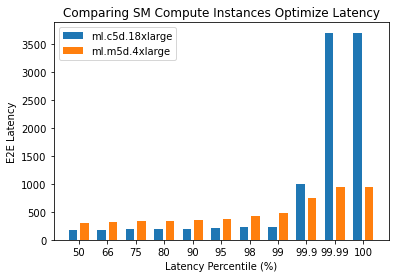

In [38]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#sns.set_style('darkgrid')
X = ['50', '66', '75', '80', '90', '95', '98', '99', '99.9','99.99', '100']
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, percentilesValuesE1, 0.3, label = 'ml.c5d.18xlarge')
plt.bar(X_axis + 0.2,percentilesValuesE2 , 0.3, label = 'ml.m5d.4xlarge')
  
plt.xticks(X_axis, X)
plt.xlabel("Latency Percentile (%)")
plt.ylabel("E2E Latency")
plt.title("Comparing SM Compute Instances Optimize Latency")
plt.legend()
plt.show()

In [29]:
locustSummary = pd.read_csv('locust.csv_stats.csv')
locustSummary.head()

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,custom_protocol_boto3,sagemaker_client_invoke_endpoint,8617,0,170,170.557851,109,1313,495501.227341,29.186077,...,180,190,190,200,200,220,220,240,1300,1300
1,NaN,Aggregated,8617,0,170,170.557851,109,1313,495501.227341,29.186077,...,180,190,190,200,200,220,220,240,1300,1300


In [30]:
locustSummary.columns

Index(['Type', 'Name', 'Request Count', 'Failure Count',
       'Median Response Time', 'Average Response Time', 'Min Response Time',
       'Max Response Time', 'Average Content Size', 'Requests/s', 'Failures/s',
       '50%', '66%', '75%', '80%', '90%', '95%', '98%', '99%', '99.9%',
       '99.99%', '100%'],
      dtype='object')

In [32]:
locustSummary = locustSummary.drop(1)
locustSummary.head()

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,custom_protocol_boto3,sagemaker_client_invoke_endpoint,8617,0,170,170.557851,109,1313,495501.227341,29.186077,...,180,190,190,200,200,220,220,240,1300,1300


# CloudWatch

In [54]:
import math
import time

statistics = ['Sum', 'SampleCount', 'Average', 'Minimum', 'Maximum']
extended = ['p50', 'p90', 'p95', 'p99', 'p100']

metrics_to_gather = []
metrics_to_gather.append('CPUUtilization')
metrics_to_gather.append('MemoryUtilization')
metrics_to_gather.append('GPUUtilization')
metrics_to_gather.append('GPUMemoryUtilization')
metrics_to_gather.append('DiskUtilization')
metrics_to_gather.append('ModelLatency')
metrics_to_gather.append('OverheadLatency')
metrics_to_gather.append('Invocations')
metrics_to_gather.append('Invocation4XXErrors')
metrics_to_gather.append('Invocation5XXErrors')
metrics_to_gather.append('InvocationsPerInstance')

def get_sample_count(cw_end, cw_start):
    
    cloudwatch = boto3.client('cloudwatch')
    metrics_to_gather=['Invocations']
    statistics=['SampleCount']
    
    factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
    period = factor * 60
    
    cloudwatch_ready = False
    
    # Keep polling CloudWatch metrics until datapoints are available
    while not cloudwatch_ready:
        time.sleep(90)
        for metric in metrics_to_gather:
            model_latency_metrics = cloudwatch.get_metric_statistics(MetricName=metric,
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics
                                             )
            if len(model_latency_metrics['Datapoints']) > 0:
                samplecount = model_latency_metrics['Datapoints'][0]['SampleCount']
                cloudwatch_ready = True
    
    return(samplecount)

def collect_cloudwatch_metrics(statistics, extended, metrics_to_gather, total_runs, cw_end, cw_start):
    
    print('Getting Cloudwatch:')
    cloudwatch = boto3.client('cloudwatch')

    # Period must be 1, 5, 10, 30, or multiple of 60
    # Calculate closest multiple of 60 to the total elapsed time
    factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
    period = factor * 60
    print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
    print('Using period of {} seconds\n'.format(period))

    cloudwatch_ready = False
    
    # Keep polling CloudWatch metrics until datapoints are available
    while not cloudwatch_ready:
        
        time.sleep(90)
        
        print('Waiting 30 seconds ...')

        for metric in metrics_to_gather:
            
            if(metric.find('Util') != -1):
                namespace = "/aws/sagemaker/Endpoints"
            else:
                namespace = "AWS/SageMaker"
            
            model_latency_metrics = cloudwatch.get_metric_statistics(MetricName=metric,
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace=namespace,
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )            
            #print(metric)
            if len(model_latency_metrics['Datapoints']) > 0:
                #print(model_latency_metrics)
                print(metric +'\n')
                side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
                side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
                side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
                side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
                side_p99 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p99'] / total_runs
                side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs

                sumcount = model_latency_metrics['Datapoints'][0]['Sum']
                samplecount = model_latency_metrics['Datapoints'][0]['SampleCount']
                average = model_latency_metrics['Datapoints'][0]['Average']
                minimum = model_latency_metrics['Datapoints'][0]['Minimum']
                maximum = model_latency_metrics['Datapoints'][0]['Maximum']

                #statistics = ['Sum', 'SampleCount', 'Average', 'Minimum', 'Maximum']
                #extended = ['p50', 'p90', 'p95', 'p99', 'p100']
                print('Avg | P50 | P90 | P95 | P95 | P100')
                print('{:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p99, side_p100))
                print('Sum | SampleCount | Average | Minimum | Maximum')
                print('{:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(sumcount, samplecount, average, minimum, maximum))
                
                cloudwatch_ready = True

In [55]:
total_runs = get_sample_count(cw_end, cw_start)
collect_cloudwatch_metrics(statistics, extended, metrics_to_gather, total_runs, cw_end, cw_start)

Getting Cloudwatch:
Time elapsed: 302.010715 seconds
Using period of 360 seconds

Waiting 30 seconds ...
CPUUtilization

Avg | P50 | P90 | P95 | P95 | P100
0.0580 | 0.0582 | 0.0585 | 0.0586 | 0.0586

Sum | SampleCount | Average | Minimum | Maximum
1.4506 | 5.0000 | 0.2901 | 0.2870 | 0.2932

MemoryUtilization

Avg | P50 | P90 | P95 | P95 | P100
0.3236 | 0.3236 | 0.3237 | 0.3237 | 0.3237

Sum | SampleCount | Average | Minimum | Maximum
8.0904 | 5.0000 | 1.6181 | 1.6178 | 1.6184

DiskUtilization

Avg | P50 | P90 | P95 | P95 | P100
0.0071 | 0.0071 | 0.0071 | 0.0071 | 0.0071

Sum | SampleCount | Average | Minimum | Maximum
0.1766 | 5.0000 | 0.0353 | 0.0353 | 0.0353

Invocations

Avg | P50 | P90 | P95 | P95 | P100
0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000

Sum | SampleCount | Average | Minimum | Maximum
0.0000 | 5.0000 | 0.0000 | 0.0000 | 0.0000

InvocationsPerInstance

Avg | P50 | P90 | P95 | P95 | P100
0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000

Sum | SampleCount | Average | Minimum | Max

In [63]:
import math
import time

statistics = ['Sum', 'SampleCount', 'Average', 'Minimum', 'Maximum']
extended = ['p50', 'p90', 'p95', 'p99', 'p100']

metrics_to_gather = []
metrics_to_gather.append('CPUUtilization')
metrics_to_gather.append('MemoryUtilization')
metrics_to_gather.append('GPUUtilization')
metrics_to_gather.append('GPUMemoryUtilization')
metrics_to_gather.append('DiskUtilization')
metrics_to_gather.append('ModelLatency')
metrics_to_gather.append('OverheadLatency')
metrics_to_gather.append('Invocations')
metrics_to_gather.append('Invocation4XXErrors')
metrics_to_gather.append('Invocation5XXErrors')
metrics_to_gather.append('InvocationsPerInstance')

def get_sample_count(cw_end, cw_start):
    
    cloudwatch = boto3.client('cloudwatch')
    metrics_to_gather=['Invocations']
    statistics=['SampleCount']
    
    factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
    period = factor * 60
    
    cloudwatch_ready = False
    
    # Keep polling CloudWatch metrics until datapoints are available
    while not cloudwatch_ready:
        time.sleep(90)
        for metric in metrics_to_gather:
            model_latency_metrics = cloudwatch.get_metric_statistics(MetricName=metric,
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics
                                             )
            if len(model_latency_metrics['Datapoints']) > 0:
                samplecount = model_latency_metrics['Datapoints'][0]['SampleCount']
                cloudwatch_ready = True
    
    return(samplecount)

def collect_cloudwatch_metrics(statistics, extended, metrics_to_gather, total_runs, cw_end, cw_start):
    
    print('Getting Cloudwatch:')
    cloudwatch = boto3.client('cloudwatch')

    # Period must be 1, 5, 10, 30, or multiple of 60
    # Calculate closest multiple of 60 to the total elapsed time
    factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
    period = factor * 60
    print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
    print('Using period of {} seconds\n'.format(period))

    cloudwatch_ready = False
    
    # Keep polling CloudWatch metrics until datapoints are available
    while not cloudwatch_ready:
        
        time.sleep(90)
        
        print('Waiting 30 seconds ...')

        for metric in metrics_to_gather:
            
            if(metric.find('Util') != -1):
                namespace = "/aws/sagemaker/Endpoints"
            else:
                namespace = "AWS/SageMaker"
            
            model_latency_metrics = cloudwatch.get_metric_statistics(MetricName=metric,
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_two_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace=namespace,
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )            
            #print(metric)
            if len(model_latency_metrics['Datapoints']) > 0:
                #print(model_latency_metrics)
                print(metric +'\n')
                side_avg = model_latency_metrics['Datapoints'][0]['Average'] / total_runs
                side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / total_runs
                side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / total_runs
                side_p95 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p95'] / total_runs
                side_p99 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p99'] / total_runs
                side_p100 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p100'] / total_runs

                sumcount = model_latency_metrics['Datapoints'][0]['Sum']
                samplecount = model_latency_metrics['Datapoints'][0]['SampleCount']
                average = model_latency_metrics['Datapoints'][0]['Average']
                minimum = model_latency_metrics['Datapoints'][0]['Minimum']
                maximum = model_latency_metrics['Datapoints'][0]['Maximum']

                #statistics = ['Sum', 'SampleCount', 'Average', 'Minimum', 'Maximum']
                #extended = ['p50', 'p90', 'p95', 'p99', 'p100']
                print('Avg | P50 | P90 | P95 | P95 | P100')
                print('{:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90, side_p95, side_p99, side_p100))
                print('Sum | SampleCount | Average | Minimum | Maximum')
                print('{:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f}\n'.format(sumcount, samplecount, average, minimum, maximum))
                
                cloudwatch_ready = True

In [64]:
total_runs = get_sample_count(cw_end, cw_start)
collect_cloudwatch_metrics(statistics, extended, metrics_to_gather, total_runs, cw_end, cw_start)

Getting Cloudwatch:
Time elapsed: 302.010715 seconds
Using period of 360 seconds

Waiting 30 seconds ...
CPUUtilization

Avg | P50 | P90 | P95 | P95 | P100
217.1179 | 257.6641 | 260.4823 | 260.8368 | 261.1206

Sum | SampleCount | Average | Minimum | Maximum
7816.2460 | 6.0000 | 1302.7077 | 496.0960 | 1567.1500

MemoryUtilization

Avg | P50 | P90 | P95 | P95 | P100
0.5438 | 0.5432 | 0.5593 | 0.5613 | 0.5630

Sum | SampleCount | Average | Minimum | Maximum
19.5784 | 6.0000 | 3.2631 | 3.1427 | 3.3804

DiskUtilization

Avg | P50 | P90 | P95 | P95 | P100
0.0173 | 0.0173 | 0.0174 | 0.0174 | 0.0174

Sum | SampleCount | Average | Minimum | Maximum
0.6246 | 6.0000 | 0.1041 | 0.1036 | 0.1046

ModelLatency

Avg | P50 | P90 | P95 | P95 | P100
94805.6104 | 93964.4762 | 105356.8075 | 111512.2272 | 132965.9511

Sum | SampleCount | Average | Minimum | Maximum
2873747663.0000 | 5052.0000 | 568833.6625 | 63195.0000 | 1304678.0000

OverheadLatency

Avg | P50 | P90 | P95 | P95 | P100
900.2121 | 720.6551 |